# 勾配ブースティング（分類）
## スクラッチ

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree


In [25]:
df = sns.load_dataset('titanic')

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [26]:
# 欠損値除去
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 1 to 889
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     182 non-null    int64   
 1   pclass       182 non-null    int64   
 2   sex          182 non-null    object  
 3   age          182 non-null    float64 
 4   sibsp        182 non-null    int64   
 5   parch        182 non-null    int64   
 6   fare         182 non-null    float64 
 7   embarked     182 non-null    object  
 8   class        182 non-null    category
 9   who          182 non-null    object  
 10  adult_male   182 non-null    bool    
 11  deck         182 non-null    category
 12  embark_town  182 non-null    object  
 13  alive        182 non-null    object  
 14  alone        182 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 18.2+ KB


In [82]:
# X, yを作成
X = df.loc[:, (df.columns != 'survived') & (df.columns!='alive')]

oe = OrdinalEncoder()
oe.set_output(transform='pandas')
X_encode = oe.fit_transform(X)

y = df['survived'].values


X_train, X_test, y_train, y_test = train_test_split(X_encode, y, test_size=0.3, random_state=0)

In [91]:

class GradientBoostingClassifier:
    def __init__(self, learning_rate=0.03, n_estimators=100, random_state=0, max_depth=1):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.max_depth = max_depth
        self.estimators = []
        
    def fit(self, X, y):
        
        # Initial model: mean of log ozz
        self.F0 = np.log(y.mean() / (1 - y.mean()))
        F0 = np.full(len(y), self.F0)
        Fb = F0
        
        for _ in range(self.n_estimators):
            p = 1 / (1 + np.exp(-Fb))
            residuals = y - p
            
            # 分類でも内部で使うのは回帰
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, residuals)
            
            # 各xが落ちる葉の場所を取得
            # print(tree.apply(X))
            X_leafs = tree.apply(X)
            leaf_ids = np.unique(X_leafs)
            # print(leaf_ids)
            # plot_tree(tree)
            for leaf_id in leaf_ids:
                fltr = X_leafs == leaf_id
                # 決定木の値
                num = residuals[fltr].sum() # 分子
                den = (p[fltr] * (1 - p[fltr])).sum() # 分母
                
                # 決定木の予測値は、決定木の葉の重みではなく、以下の計算式の値とする。
                # 弱学習器の出力を上書き
                tree_pred_proba = num / den
                tree.tree_.value[leaf_id, 0, 0] = tree_pred_proba
                Fb[fltr] += self.learning_rate * tree_pred_proba
                # print("######")
                # print(tree.tree_.value) 
                #これを確認すると、[num_nodes, num_outputs, num_classes]の要素で並んでいることが分かる・
                #決定木で回帰を行っているので、num_outputs, num_classesはそれぞれ0
            self.estimators.append(tree)
            
    def predict_proba(self,X):
        
        Fb = np.full(X.shape[0] ,self.F0)
        
        
        for estimator in self.estimators:
            Fb += self.learning_rate * estimator.predict(X)
        
        # シグモイド関数に入れて確率の形式にする
        return 1 / (1 + np.exp(-Fb))

In [92]:
# よく使うnpメソッド
np.full(10,3)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [93]:
my_gbc = GradientBoostingClassifier()
my_gbc.fit(X_train ,y_train)

In [94]:
my_gbc.predict_proba(X_test)

array([0.5514342 , 0.4329777 , 0.80125347, 0.80125347, 0.5514342 ,
       0.25797762, 0.5514342 , 0.83715418, 0.88099514, 0.88099514,
       0.5514342 , 0.82137752, 0.82137752, 0.88099514, 0.5514342 ,
       0.5514342 , 0.5514342 , 0.82137752, 0.88099514, 0.40100637,
       0.88099514, 0.78760146, 0.88099514, 0.88099514, 0.80125347,
       0.5514342 , 0.40100637, 0.80125347, 0.4329777 , 0.4329777 ,
       0.4329777 , 0.88099514, 0.88099514, 0.88099514, 0.82137752,
       0.88099514, 0.82137752, 0.88099514, 0.40100637, 0.5514342 ,
       0.4329777 , 0.82137752, 0.5514342 , 0.78760146, 0.40100637,
       0.88099514, 0.88099514, 0.5514342 , 0.5514342 , 0.5514342 ,
       0.5514342 , 0.82137752, 0.5514342 , 0.88099514, 0.88099514])

## sklearnのクラスを使う

In [102]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=0.03, n_estimators=100, random_state=0, max_depth=1)
gbc.fit(X_train, y_train)

y_pred = gbc.predict_proba(X_test)[:, 1]

In [103]:
y_pred

array([0.5514342 , 0.4329777 , 0.80125347, 0.80125347, 0.5514342 ,
       0.25797762, 0.5514342 , 0.83715418, 0.88099514, 0.88099514,
       0.5514342 , 0.82137752, 0.82137752, 0.88099514, 0.5514342 ,
       0.5514342 , 0.5514342 , 0.82137752, 0.88099514, 0.40100637,
       0.88099514, 0.78760146, 0.88099514, 0.88099514, 0.80125347,
       0.5514342 , 0.40100637, 0.80125347, 0.4329777 , 0.4329777 ,
       0.4329777 , 0.88099514, 0.88099514, 0.88099514, 0.82137752,
       0.88099514, 0.82137752, 0.88099514, 0.40100637, 0.5514342 ,
       0.4329777 , 0.82137752, 0.5514342 , 0.78760146, 0.40100637,
       0.88099514, 0.88099514, 0.5514342 , 0.5514342 , 0.5514342 ,
       0.5514342 , 0.82137752, 0.5514342 , 0.88099514, 0.88099514])

In [105]:
from sklearn.metrics import roc_auc_score
print(f"grad boost AUC: {roc_auc_score(y_test, y_pred)}")

grad boost AUC: 0.9407051282051282


In [110]:
results = []
for t in gbc.estimators_:
    result = 0.03 * t[0].predict([X_test.iloc[0]])
    results.append(result)

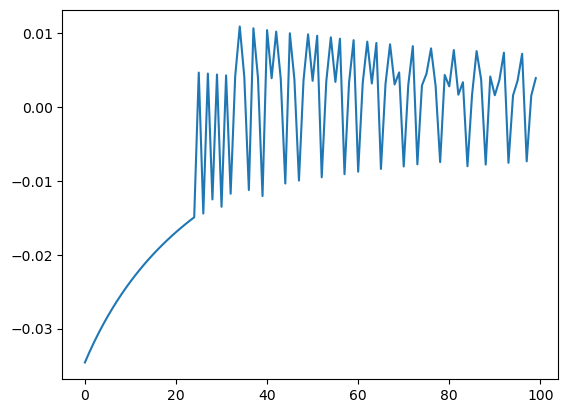

In [111]:
import matplotlib.pyplot as plt
plt.plot(results)

In [113]:
F0 = np.log(y_train.mean() / (1 - y_train.mean()))
Fb = F0 + np.cumsum(results)[-1]
Fb

0.2064671274951857

In [115]:
predict = 1 / (1 + np.exp(-Fb))
predict

0.551434197251246

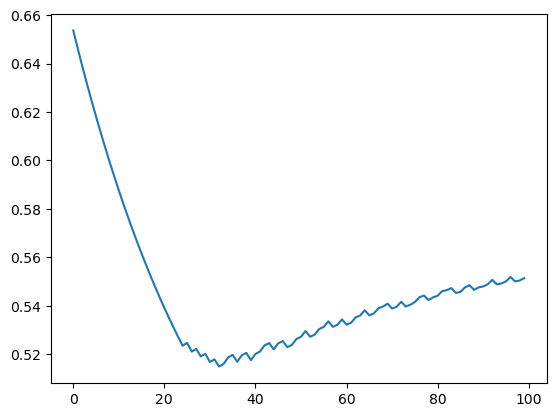

In [117]:
plt.plot(1 / (1 + np.exp(-(F0 + np.cumsum(results)))))